In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [44]:
RECORDING_FOLDER_PATH = "../Recordings/"

def label_saccades( eye_data_json, supervised_saccades_txt, id ) -> pd.DataFrame:
    df = pd.read_json( f'{RECORDING_FOLDER_PATH}{eye_data_json}' )
    df.insert( 0, "id", id )
    df.insert( 0, "isSaccade", 0 )
    txt = open( f'{RECORDING_FOLDER_PATH}{supervised_saccades_txt}' )
    for line in txt:
        line = line.rstrip().split(':')
        lower_bound = int( line[0] )
        upper_bound = int( line[1] )
        df.loc[ (df.microTimestamp >= lower_bound) & (df.microTimestamp <= upper_bound), 'isSaccade' ] = 1

    # Remove all invalid rows
    df = df[df['gazeRayIsValid'] & df['rightGazeRayIsValid'] & df['leftGazeRayIsValid']]
    df = df.reset_index()
    return df

df1 = label_saccades( "jess-recording-1.json", "jess-saccades-1.txt", 0 )
df2 = label_saccades( "jess-recording-2.json", "jess-saccades-2.txt", 0 )
df3 = label_saccades( "teran-recording-1.json", "teran-saccades-1.txt", 1 )
# df4 = label_saccades( "luke-recording-1.json", "luke-saccades-1.txt", 2 )
df5 = label_saccades( "luke-recording-2.json", "luke-saccades-1.txt", 2 )

# df = df1 # Jess
# df = df2 # Jess
# df = df3 # Teran
# df = df4 # Luke
# df = df5 # Luke
df = pd.concat([df1, df2, df3, df5])
targets = df['isSaccade']
timestamps = df['milliTimestamp']
print(df)

df = df.drop(
        columns=[
            'systemTimestamp',
            'deviceTimestamp',
            'microTimestamp',
            'milliTimestamp',
            'secTimestamp',
            'minTimestamp',
            "isSaccade",
            "id",
            'leftGazeRayIsValid',
            'leftEyeIsBlinking',
            'leftPupilDiameterIsValid',
            'leftPositionGuideIsValid',
            'rightGazeRayIsValid',
            'rightEyeIsBlinking',
            'rightPupilDiameterIsValid',
            'rightPositionGuideIsValid',
            'gazeRayIsValid',
            'convergenceDistanceIsValid'
        ]
    )

df_left_eye = df.drop(
        columns=[
            'rightGazeRayDirectionX',
            'rightGazeRayDirectionY',
            'rightGazeRayDirectionZ',
            'rightGazeRayOriginX',
            'rightGazeRayOriginY',
            'rightGazeRayOriginZ',
            'rightPupilDiameter',
            'rightPositionGuideX',
            'rightPositionGuideY'
        ]
    )

df_right_eye = df.drop(
        columns=[
            'leftGazeRayDirectionX',
            'leftGazeRayDirectionY',
            'leftGazeRayDirectionZ',
            'leftGazeRayOriginX',
            'leftGazeRayOriginY',
            'leftGazeRayOriginZ',
            'leftPupilDiameter',
            'leftPositionGuideX',
            'leftPositionGuideY'
        ]
    )

      index  isSaccade  id  systemTimestamp  deviceTimestamp  microTimestamp  \
0         0          0   0      93645260524      93645260574              12   
1         1          0   0      93645271638      93645271688             485   
2         2          0   0      93645282752      93645282802             544   
3         3          0   0      93645293866      93645293916             597   
4         4          0   0      93645304980      93645305030             703   
...     ...        ...  ..              ...              ...             ...   
3250   3350          1   2        745218040        745218170        36954598   
3251   3351          1   2        745229154        745229284        36968399   
3252   3352          1   2        745240268        745240398        36968568   
3253   3353          1   2        745251382        745251512        36982621   
3254   3354          1   2        745262496        745262626        36996535   

      milliTimestamp  secTimestamp  min

In [ ]:
# Find the average distance between the left and right eye direction vectors
x1_coords = df['leftGazeRayDirectionX'].to_numpy()
y1_coords = df['leftGazeRayDirectionY'].to_numpy()
z1_coords = df['leftGazeRayDirectionZ'].to_numpy()
x2_coords = df['rightGazeRayDirectionX'].to_numpy()
y2_coords = df['rightGazeRayDirectionY'].to_numpy()
z2_coords = df['rightGazeRayDirectionZ'].to_numpy()

p1 = np.array([x1_coords, y1_coords, z1_coords])
p2 = np.array([x2_coords, y2_coords, z2_coords])

squared_dist = np.sum((p1-p2)**2, axis=0)
dist = np.sqrt(squared_dist)

# Remove extreme outliers using IQR
q75, q25 = np.percentile( dist, [75, 25] )
iqr = q75 - q25
cut_off = iqr * 1.5
lower_bound, upper_bound = q25 - cut_off, q75 + cut_off

outliers = []
indices = []
for i in range(0, len(dist)):
    if (dist[i] < lower_bound) or (dist[i] > upper_bound):
        outliers.append(dist[i])
        indices.append(i)

new_dist = np.delete(dist, indices)
new_times = timestamps.drop(index=indices).values
avg_dist = np.average(new_dist)
print(f"Average distance: {avg_dist}")

d = { 'distance': new_dist, 'time': new_times }
ax = sns.lineplot(data=d, x='time', y='distance')
ax.set_title("Distance Between Left and Right Eye Gaze")
ax.set_xlabel("Time (Milliseconds)")
ax.set_ylabel("Distance")
ax.set_ylim(0,0.2)
# plt.savefig(f"left_right_eye_gaze_distance_plot_teran.png", bbox_inches='tight', dpi=200)
plt.show()

In [ ]:
def loading_plot(
            coeff, labels, scale=1, colors=None, visible=None, ax=plt, arrow_size=0.5
        ):
            for i, label in enumerate(labels):
                if visible is None or visible[i]:
                    ax.arrow(
                        0,
                        0,
                        coeff[i, 0] * scale,
                        coeff[i, 1] * scale,
                        head_width=arrow_size * scale,
                        head_length=arrow_size * scale,
                        color="#000" if colors is None else colors[i],
                    )
                    ax.text(
                        coeff[i, 0] * 1.15 * scale,
                        coeff[i, 1] * 1.15 * scale,
                        label,
                        color="#000" if colors is None else colors[i],
                        ha="center",
                        va="center",
                    )
def pca_plot(dataframe: pd.DataFrame, targets: pd.DataFrame, str_plot_name: str):
    pipeline = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=2)),])

    pca_data = pd.DataFrame(
        pipeline.fit_transform(dataframe),
        columns=["PC1", "PC2"],
        index=dataframe.index,
    )

    pca_data['movementType'] = targets
    pca_step = pipeline.steps[1][1]
    loadings = pd.DataFrame(
        pca_step.components_.T,
        columns=["PC1", "PC2"],
        index=dataframe.columns,
    )

    g = sns.scatterplot(data=loadings, x="PC1", y="PC2", hue=dataframe.columns)
    x = pca_step.explained_variance_ratio_[0]
    y = pca_step.explained_variance_ratio_[1]

    # Add variance explained
    g.set_xlabel(f"PC1 ({x*100:.2f} %)")
    g.set_ylabel(f"PC2 ({y*100:.2f} %)")
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    plt.savefig(f"{str_plot_name}.png", bbox_inches='tight', dpi=200)

In [45]:
# Train and Test Data Seperation
X_train, X_test, Y_train, Y_test = train_test_split(df, targets, test_size=0.25, 
                                                    stratify=targets, random_state=30)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

train feature shape:  (11004, 26)
test feature shape:  (3668, 26)


In [46]:
# For PCA, First Need to Scale the Data.  
scaler1 = StandardScaler()
scaler1.fit(df)
feature_scaled = scaler1.transform(df)

# Now Apply PCA
pca1 = PCA(n_components=4)
pca1.fit(feature_scaled)
feature_scaled_pca = pca1.transform(feature_scaled)
print("shape of the scaled and 'PCA'ed features: ", np.shape(feature_scaled_pca))

shape of the scaled and 'PCA'ed features:  (14672, 4)


In [47]:
# Let's see the variance to see out of the 
# 4 components which are contributing most 

feat_var = np.var(feature_scaled_pca, axis=0)
feat_var_rat = feat_var/(np.sum(feat_var))

print ("Variance Ratio of the 4 Principal Components Ananlysis: ", feat_var_rat)

Variance Ratio of the 4 Principal Components Ananlysis:  [0.4171095  0.26616138 0.19938051 0.11734861]


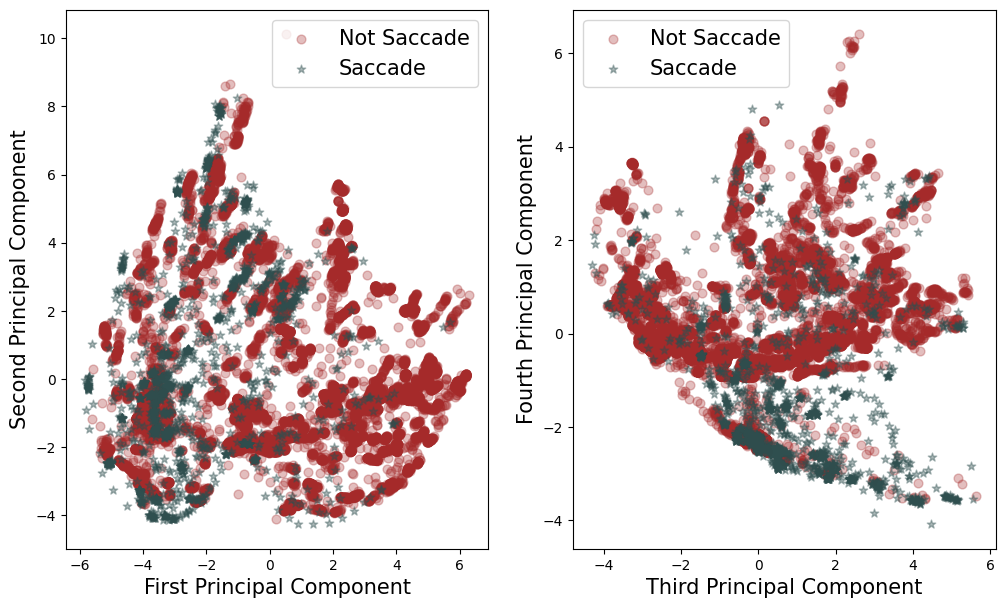

In [48]:
feature_scaled_pca_X0 = feature_scaled_pca[:, 0]
feature_scaled_pca_X1 = feature_scaled_pca[:, 1]
feature_scaled_pca_X2 = feature_scaled_pca[:, 2]
feature_scaled_pca_X3 = feature_scaled_pca[:, 3]

labels = targets
colordict = {0:'brown', 1:'darkslategray'}
piclabel = {0:'Not Saccade', 1:'Saccade'}
markers = {0:'o', 1:'*'}
alphas = {0:0.3, 1:0.4}

fig = plt.figure(figsize=(12, 7))
plt.subplot(1,2,1)
for l in np.unique(labels):
    ix = np.where(labels==l)
    plt.scatter(feature_scaled_pca_X0[ix], feature_scaled_pca_X1[ix], c=colordict[l], 
            label=piclabel[l], s=40, marker=markers[l], alpha=alphas[l])
plt.xlabel("First Principal Component", fontsize=15)
plt.ylabel("Second Principal Component", fontsize=15)

plt.legend(fontsize=15)

plt.subplot(1,2,2)
for l1 in np.unique(labels):
    ix1 = np.where(labels==l1)
    plt.scatter(feature_scaled_pca_X2[ix1], feature_scaled_pca_X3[ix1], c=colordict[l1], 
            label=piclabel[l1], s=40, marker=markers[l1], alpha=alphas[l1])
plt.xlabel("Third Principal Component", fontsize=15)
plt.ylabel("Fourth Principal Component", fontsize=15)

plt.legend(fontsize=15)

# plt.savefig('Saccade_labels_PCAs.png', dpi=200)
plt.show()

In [49]:
# Pipeline Steps are StandardScaler, PCA and SVM 
pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('SupVM', SVC(kernel='rbf'))]

check_params= {
    'pca__n_components': [2], 
    'SupVM__C': [0.1, 0.5, 1, 10,30, 40, 50, 75, 100, 500, 1000], 
    'SupVM__gamma' : [0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]
}

pipeline = Pipeline(pipe_steps)

In [50]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

print ("Start Fitting Training Data")
for cv in tqdm(range(4,6)):
    create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
    create_grid.fit(X_train, Y_train)
    print ("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, Y_test)))
    print ("!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!")
    print (create_grid.best_params_)

print ("out of the loop")

Start Fitting Training Data


  0%|          | 0/2 [00:00<?, ?it/s]

score for 4 fold CV := 0.94
!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'SupVM__C': 10, 'SupVM__gamma': 50, 'pca__n_components': 2}
score for 5 fold CV := 0.94
!!!!!!!! Best-Fit Parameters From Training Data !!!!!!!!!!!!!!
{'SupVM__C': 50, 'SupVM__gamma': 10, 'pca__n_components': 2}
out of the loop


In [51]:
print ("grid best params: ", create_grid.best_params_) 
# use the best one

grid best params:  {'SupVM__C': 50, 'SupVM__gamma': 10, 'pca__n_components': 2}


0.9402944383860414
0.9402944383860414


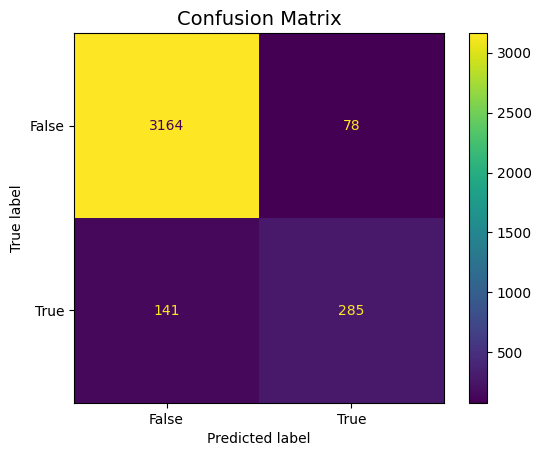

In [62]:
# Time for Prediction and Plotting Confusion Matrix
from sklearn import metrics
import seaborn as sns

Y_pred = create_grid.predict(X_test)
# print (Y_pred)
cm = metrics.confusion_matrix(Y_test, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()

recall_score = metrics.recall_score(Y_test, Y_pred, average='micro')
precision_score = metrics.precision_score(Y_test, Y_pred, average='micro')
print(recall_score)
print(precision_score)
# sns.heatmap(cm_display, annot=True, cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)
plt.show()

initial decision function shape;  (20720,)
after reshape:  (148, 140)


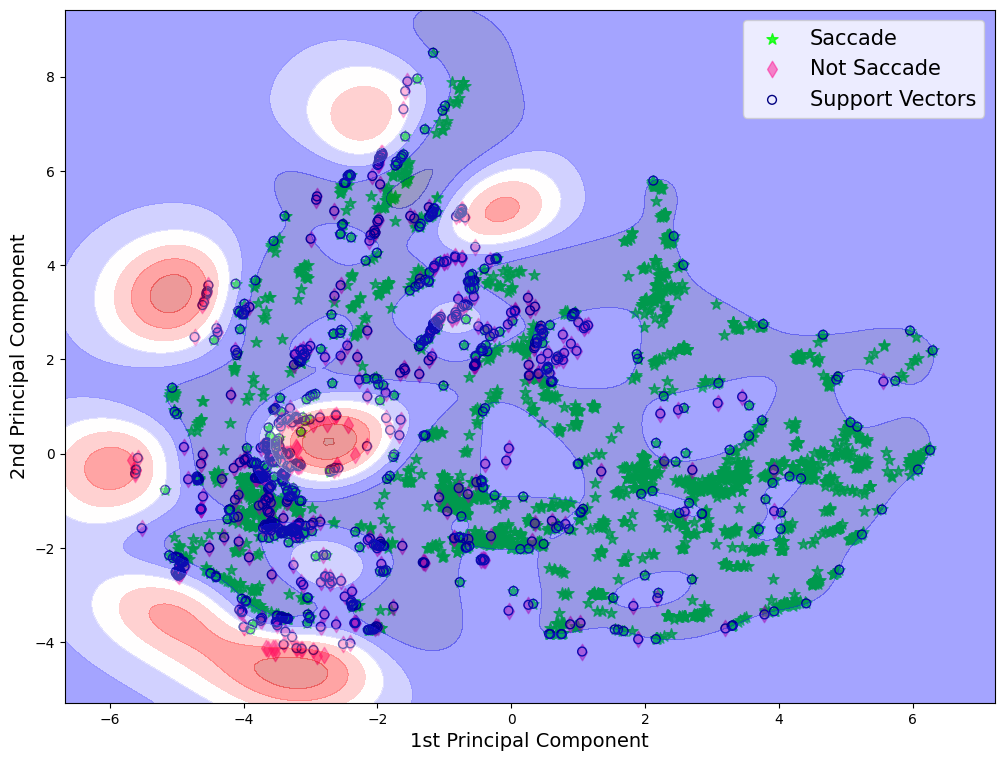

In [58]:
# 2D Decision Boundary

scaler1 = StandardScaler()
scaler1.fit(X_test)
X_test_scaled = scaler1.transform(X_test)


pca2 = PCA(n_components=2)
X_test_scaled_reduced = pca2.fit_transform(X_test_scaled)


# svm_model = SVC(kernel='rbf', C=float(create_grid.best_params_['SupVM__C']), 
#                 gamma=float(create_grid.best_params_['SupVM__gamma']))

svm_model = SVC(kernel='rbf', C=1., gamma=0.5)

classify = svm_model.fit(X_test_scaled_reduced, Y_test)

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    print ('initial decision function shape; ', np.shape(Z))
    Z = Z.reshape(xx.shape)
    print ('after reshape: ', np.shape(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.1):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))#,
                        #np.arange(z_min, z_max, h))
    return xx, yy

X0, X1 = X_test_scaled_reduced[:, 0], X_test_scaled_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_facecolor('white')
cdict1={0:'lime',1:'deeppink'}

Y_tar_list = Y_test.tolist()
yl1= [int(target1) for target1 in Y_tar_list]
labels1=yl1

labl1={0:'Saccade',1:'Not Saccade'}
marker1={0:'*',1:'d'}
alpha1={0:.8, 1:0.5}

for l1 in np.unique(labels1):
    ix1=np.where(labels1==l1)
    ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=70,marker=marker1[l1],alpha=alpha1[l1])

ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], s=40, facecolors='none', 
        edgecolors='navy', label='Support Vectors')

plot_contours(ax, classify, xx, yy,cmap='seismic', alpha=0.4)
plt.legend(fontsize=15)

plt.xlabel("1st Principal Component",fontsize=14)
plt.ylabel("2nd Principal Component",fontsize=14)


# plt.savefig(f'{svm_file_name}.png', dpi=300)
plt.savefig('ClassifySaccade_NotSaccade2D_Decs_FunctG10.png', dpi=300)
plt.show()

In [ ]:
# pca_plot(df_left_eye, targets, "2D_PCA_with_loadings_left_eye")

In [ ]:
# pca_plot(df_right_eye, targets, "2D_PCA_with_loadings_right_eye")

In [ ]:
# pca_plot(df, targets, "2D_PCA_with_loadings_teran")

In [ ]:
# pca_plot(df, targets, "2D_PCA_with_loadings_jess")

In [ ]:
# pca_plot(df, targets, "2D_PCA_with_loadings_luke")

In [ ]:
# run_pca_and_svm(df_left_eye, targets, "ClassifySaccade_NotSaccade2D_Teran_left_eye")

In [ ]:
# run_pca_and_svm(df_right_eye, targets, "ClassifySaccade_NotSaccade2D_Teran_right_eye")

In [ ]:
# run_pca_and_svm(df, targets, "ClassifySaccade_NotSaccade2D_Teran_both_eyes")